# PA004 - HEALTH INSURANCE CROSS-SELL_STUDY_1

## 0 - IMPORTS

In [1]:
import warnings
import random
import pickle

import pandas                as pd
import numpy                 as np
import seaborn               as sns
import scikitplot            as skplt
import plotly.express        as px
import matplotlib.patches    as mpatches
import lightgbm              as lgbm

from IPython.core.display    import HTML
from IPython.display         import Image
from xgboost                 import XGBClassifier
from xgboost                 import XGBRegressor
from collections             import Counter
from catboost                import CatBoostClassifier

from scipy                   import stats                     as ss
from matplotlib              import pyplot                    as plt
from sklearn                 import preprocessing             as pp
from sklearn                 import model_selection           as ms
from sklearn                 import ensemble                  as en
from sklearn                 import neighbors                 as nh
from sklearn                 import linear_model              as lm

warnings.filterwarnings( 'ignore' )

### 0.1 - Helper Functions

In [2]:
def recall_at_k (data, k=2000):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k'] 

def precision_at_k (data, k=2000):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def cramer_v( x, y):
    cm = pd.crosstab( x, y).values   
    n = cm.sum()
    r, k = cm.shape    
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1) 
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def prediction_score(model, data):
    # Separating train and validation dataset for each kfold
    x_train = data.drop(columns=['response'])
    y_train = data['response']
    
    # prediction probability (score)
    yhat_proba = model.predict_proba(x_train)[:, 1].tolist()
    
    # merging score to dataset
    data_scored = data.copy()
    data_scored['score'] = yhat_proba
    
    # sort
    data_scored = data_scored.sort_values('score', ascending=False)
    
    # precision and recall
    data_scored = data_scored.reset_index(drop=True)
    data_scored['n_samples'] = data_scored.index + 1
    data_scored['precision_at_k'] = data_scored['response'].cumsum() / data_scored['n_samples']
    data_scored['recall_at_k'] = data_scored['response'].cumsum() / data_scored['response'].sum()
    
    return data_scored

def cross_validation(kfold, modelName, model, data, at_k):
    # Number of folds
    fold=ms.StratifiedKFold(n_splits = kfold, shuffle=True, random_state=42)
    
    # Performance variables
    precision_list = []
    recall_list = []
    cv_performance = {}
    
    for train_cv,val_cv in fold.split(data, data['response']):
        
        # Separating train and validation dataset for each kfold
        # training data
        x_train_fold = data.iloc[train_cv]
        x_train_fold = x_train_fold[cols_selected]
        
        y_train_fold = data['response'].iloc[train_cv]
        
        # validation data
        x_val_fold = data.iloc[val_cv]
        x_val_fold = x_val_fold[cols_selected]
        
        y_val_fold = data['response'].iloc[val_cv]
        
        # fitting the model
        model_fitted = model.fit(x_train_fold,y_train_fold)
        
        # getting the prediction probability
        x_val_fold['response'] = y_val_fold
        val_scored = prediction_score(model_fitted, x_val_fold)
        
        # Getting precision and recall at k
        precision = val_scored.loc[at_k, 'precision_at_k']
        recall = val_scored.loc[at_k, 'recall_at_k']
        
        precision_list.append(precision)
        recall_list.append(recall)
        
    # calculating the mean and std performance of all kfolds
    precision_cv = np.round(np.mean(precision_list),4).astype(float)
    std_precision_cv = '+/-' + np.round(np.std(precision_list),4).astype(str)
    recall_cv = np.round(np.mean(recall_list),4).astype(float)
    std_recall_cv = ' +/- ' + np.round(np.std(recall_list),4).astype(str)
        
    cv_performance[modelName] = [precision_cv, std_precision_cv, recall_cv, std_recall_cv]
    model_performance_cv = pd.DataFrame(cv_performance, index=['precision_at_k', 'std_precision', 'recall_at_k', 'std_recall'])

    return model_performance_cv

def ml_performance( model_name, precision_atK, recall_atK ):
    
    return pd.DataFrame( {'Model Name': model_name,
                          'Precision_at_K': precision_atK,
                          'Recall_at_K': recall_atK}, index=[0])

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container {width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1 - DATAS

In [4]:
# Linux
#df = pd.read_csv('/home/reng/Documents/ds_repos/Projects/Health_Insurance_Cross_Sell/data/raw/data.csv')

# Train Datas - Windows
df = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/data.csv')

# Test Datas - Windows
#df_test = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/test.csv')

### 1.2 - Data Description

#### 1.2.1 - Data Dimensions

In [ ]:
print( 'Number of Rows: {}'.format( df.shape[0] ) )
print( 'Number of Cols: {}'.format( df.shape[1] ) )

#### 1.2.2 - Data Types

In [ ]:
df.dtypes

In [ ]:
# Changing data types
#df['region_code'] = df['region_code'].astype(object)
#df['policy_sales_channel'] = df['policy_sales_channel'].astype(object)

#### 1.2.3 - Check NA

In [ ]:
df.isna().sum()

#### 1.2.4 - Columns Description

In [ ]:
df.columns

* **Id**: Unique ID for the customer.
* **Gender**: Gender of the customer.
* **Age**: Age of the customer.
* **Driving_License**: **0**: Customer does not have drive license **1** : Customer already has drive license.
* **Region_Code**: Unique code for the region of the customer.
* **Previously_Insured**: **1** : Customer already has Vehicle Insurance, **0** : Customer doesn't have Vehicle Insurance.
* **Vehicle_Age**: Age of the Vehicle.
* **Vehicle_Damage**: **1** : Customer got his/her vehicle damaged in the past. **0** : Customer didn't get his/her vehicle damaged in the past.
* **Annual_Premium**: The amount customer needs to pay as premium in the year.
* **Policy_Sales_Channel**: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* **Vintage**: Number of Days, Customer has been associated with the company.
* **Response**: **1** : Customer is interested, **0** : Customer is not interested.

#### 1.2.5 - Data Descriptive

In [ ]:
# Select columns where the content is different 0 or 1.
num_attributes = df[['age','annual_premium','vintage']]
cat_attributes = df[['driving_license','region_code','policy_sales_channel','previously_insured','gender','vehicle_age','vehicle_damage']]
target_atribute = df['response']

In [ ]:
num_attributes.hist(bins=25, figsize = (10, 5 ));

In [ ]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

In [ ]:
fig, axs = plt.subplots(3, figsize = (8, 10))
sns.distplot(df['age'], ax=axs[0], bins=6)
sns.distplot(df[df['annual_premium']<100000]['annual_premium'], ax=axs[1])
sns.distplot(df['vintage'], ax=axs[2]);

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize= (15, 8))

sns.countplot(x = 'driving_license', data=df, ax=axs[0][0])
sns.countplot(x = 'previously_insured', data=df, ax=axs[0][1])
sns.countplot(x = 'gender', data=df, ax=axs[0][2])
sns.countplot(x = 'vehicle_age', data=df, ax=axs[1][0])
sns.countplot(x = 'vehicle_damage', data=df, ax=axs[1][1])

In [ ]:
fig = plt.subplots(figsize = (15,5))
sns.countplot(x='region_code', data=df)

In [ ]:
policy_1 = df['policy_sales_channel'].value_counts().iloc[0:55]
policy_1 = policy_1.reset_index()
policy_2 = df['policy_sales_channel'].value_counts().iloc[55:110]
policy_2 = policy_2.reset_index()
policy_3 = df['policy_sales_channel'].value_counts().iloc[110:156]
policy_3 = policy_3.reset_index()

fig, axs = plt.subplots(ncols=3, figsize=(15,15))
sns.barplot(y='index', x='policy_sales_channel', data=policy_1, ax=axs[0], orient='h', order=policy_1['index'])
sns.barplot(y='index', x='policy_sales_channel', data=policy_2, ax=axs[1], orient='h', order=policy_2['index'])
sns.barplot(y='index', x='policy_sales_channel', data=policy_3, ax=axs[2], orient='h', order=policy_3['index'])

## 2 - FEATURE ENGINEERING

In [5]:
df2 = df.copy()

# Ajustando coluna vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else
                                                        2 if (x == '1-2 Year') else
                                                        3)
# Ajustando coluna vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)

### 2.3 - FEATURE ENGINEERING

In [6]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,1,1,0,23367,249,0
1,13,Female,41,15,14,1,2,0,1,31409,221,0
2,18,Female,25,35,152,1,1,0,1,46622,299,0
3,31,Female,26,8,160,1,1,0,0,2630,136,0
4,39,Male,45,8,124,1,2,1,0,42297,264,0


#### 2.3.1 - New Features

In [7]:
df2['age_group'] = df2['age'].apply(lambda x: 1 if (x >= 18 | x < 30 ) else
                                                        2 if (x >= 30 | x < 60 ) else
                                                        3)
df2['vintage_month'] = round(df2['vintage'] / 31)

In [8]:
df2['age_group'] = df2['age'].apply(lambda x: 1 if (x >= 18 | x < 30 ) else
                                                        2 if (x >= 30 | x < 60 ) else
                                                        3)
df2['vintage_month'] = round(df2['vintage'] / 31)



In [9]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,age_group,vintage_month
0,7,Male,23,11,152,1,1,1,0,23367,249,0,1,8.0
1,13,Female,41,15,14,1,2,0,1,31409,221,0,3,7.0
2,18,Female,25,35,152,1,1,0,1,46622,299,0,3,10.0
3,31,Female,26,8,160,1,1,0,0,2630,136,0,1,4.0
4,39,Male,45,8,124,1,2,1,0,42297,264,0,3,9.0


## 3 - DATA FILTERING

In [10]:
df3 = df2.copy()

## 4 - EDA

In [11]:
df4 = df3.copy()

### 4.1 -  Univariate Analysis

In [ ]:
# response
one = df4[['id','response']].groupby('response').count().reset_index()

sns.barplot( x='response', y='id', data=one)

In [ ]:
# 'age'

plt.subplot(1,3,1)
sns.boxplot( x='response', y='age', data=df4)

plt.subplot(1,3,2)
aux1 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux1)

plt.subplot(1,3,3)
aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux1)

In [ ]:
# 'annual_premium'
plt.subplot(1,3,1)
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux)

plt.subplot(1,3,2)
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux1 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux1)

plt.subplot(1,3,3)
aux1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux1)

In [ ]:
# 'driving_license'
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()

plt.figure(figsize=(7,5))
sns.barplot( x='response', y='driving_license', data=aux)

In [ ]:
#'region_code'
aux = df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()
plt.figure(figsize=(7,5))
sns.scatterplot( x='region_code', y='id', hue='response', data=aux )

In [ ]:
# 'previously_insured'
pi = pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )
pi_stack = pi.stack().reset_index().rename(columns={0:'value'})
plt.figure(figsize=(7,5))
sns.barplot( x= pi_stack.previously_insured, y= pi_stack.value, hue=pi_stack.response)

In [ ]:
#'gender'
gen = pd.crosstab( df4['gender'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )
gen_stack = gen.stack().reset_index().rename(columns={0:'value'}) 
plt.figure(figsize=(7,5))
sns.barplot( x= gen_stack.gender, y= gen_stack.value, hue=gen_stack.response )

In [ ]:
# 'vehicle_age'
veh_age = df4[['vehicle_age','response']].value_counts( normalize=True ).reset_index()
veh_age = veh_age.rename(columns={0:'value'}) 
plt.figure(figsize=(7,5))
sns.barplot( x= veh_age.vehicle_age, y= veh_age.value, hue=veh_age.response )

In [ ]:
# 'vehicle_damage'
veh_dam = pd.crosstab( df4['vehicle_damage'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )
veh_dam = veh_dam.stack().reset_index().rename(columns={0:'value'})
plt.figure(figsize=(7,5))
sns.barplot( x= veh_dam.vehicle_damage, y= veh_dam.value, hue=veh_dam.response )

In [ ]:
# 'age_group'
age_gro = pd.crosstab( df4['age_group'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )
age_gro = age_gro.stack().reset_index().rename(columns={0:'value'})
plt.figure(figsize=(7,5))
sns.barplot( x= age_gro.age_group, y= age_gro.value, hue=age_gro.response )

In [ ]:
# 'vintage_month'
vintage_month = df4[['vintage_month','response']].value_counts( normalize=True ).reset_index()
vintage_month = vintage_month.rename(columns={0:'value'}) 
plt.figure(figsize=(7,5))
sns.barplot( x= vintage_month.vintage_month, y= vintage_month.value, hue=vintage_month.response )

In [ ]:
# 'policy_sales_channel'
# set the figure size
plt.figure(figsize=(25, 10))

# from raw value to percentage
total = df4.groupby('policy_sales_channel')['id'].count().reset_index()
response_1 = df4.loc[df4.response == 1 ].groupby('policy_sales_channel')['id'].count().reset_index()
response_0 = df4.loc[df4.response == 0 ].groupby('policy_sales_channel')['response'].sum().reset_index()
resp = pd.merge(response_1, response_0, how = 'outer', on = 'policy_sales_channel')
resp['id'] = resp['id'].fillna(0)
resp = resp.sort_values(by='policy_sales_channel')
resp['id'] = [i / j * 100 for i,j in zip(resp['id'], total['id'])]
total['id'] = [i / j * 100 for i,j in zip(total['id'], total['id'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="policy_sales_channel",  y="id", data=total, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="policy_sales_channel", y="id", data=resp, color='lightblue')

# add legend
plt.xticks(rotation=90)
top_bar = mpatches.Patch(color='darkblue', label='response = No')
bottom_bar = mpatches.Patch(color='lightblue', label='response = Yes')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

In [ ]:
# 'vintage'
plt.subplot( 1,3,1 )
sns.barplot( x='response', y='vintage', data=df4)

plt.subplot( 1,3,2 )
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux )

plt.subplot( 1,3,3 )
aux = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux )

In [ ]:
# Age Group
plt.subplot( 1,3,1 )
sns.barplot( x='response', y='age_group', data=df4)

plt.subplot( 1,3,2 )
aux = df4.loc[df4['response'] == 0, 'age_group']
sns.histplot( aux )

plt.subplot( 1,3,3 )
aux = df4.loc[df4['response'] == 1, 'age_group']
sns.histplot( aux )

In [ ]:
# Vintage Month
plt.subplot( 1,3,1 )
sns.barplot( x='response', y='vintage_month', data=df4)

plt.subplot( 1,3,2 )
aux = df4.loc[df4['response'] == 0, 'vintage_month']
sns.histplot( aux )

plt.subplot( 1,3,3 )
aux = df4.loc[df4['response'] == 1, 'vintage_month']
sns.histplot( aux )

In [ ]:
# Annual Premium per Day
plt.subplot( 1,3,1 )
sns.barplot( x='response', y='annual_premium_per_day', data=df4)

plt.subplot( 1,3,2 )
aux = df4.loc[df4['response'] == 0, 'annual_premium_per_day']
sns.histplot( aux )

plt.subplot( 1,3,3 )
aux = df4.loc[df4['response'] == 1, 'annual_premium_per_day']
sns.histplot( aux )

In [ ]:
# Annual Premium per Group Age
plt.subplot( 1,3,1 )
sns.barplot( x='response', y='annual_premium_per_age', data=df4)

plt.subplot( 1,3,2 )
aux = df4.loc[df4['response'] == 0, 'annual_premium_per_age']
sns.histplot( aux )

plt.subplot( 1,3,3 )
aux = df4.loc[df4['response'] == 1, 'annual_premium_per_age']
sns.histplot( aux )

### 4.2 - Bivariate Analysis

In [ ]:
df2.head()

In [ ]:
#1.The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance. (FALSE)
d1 = df2[( df2['previously_insured'] == 0) & (df2['vehicle_damage'] == 1)]

ax1 = d1[['response','id']].groupby('response').count().reset_index()
ax1['percentage'] = round(ax1['id'] / d1['id'].count()*100)
ax1

In [ ]:
# 2. The interest on purchase the vehicle insurance is greater for woman than men. (FALSE)
aux2 = pd.crosstab(df2['gender'], df2['response'])
aux2['percentage'] = aux2[1]/(aux2[0]+aux2[1])
aux2

In [ ]:
# 3. The interest on purchase vehicle insurance is greater for vintage customers( 7 months or more )
aux3 = df2[df2['vintage_month'] >= 7 ][['id','response']]
aux4 = df2[df2['vintage_month'] < 7 ][['id','response']]

fix, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.countplot(x = aux3['response'], ax=axs[0]).set_title('Vintage Customer: 7 months or more')
sns.countplot(x = aux4['response'], ax=axs[1]).set_title('Vintage Customer: 7 months or less')

In [ ]:
aux18 = aux3[['response','id']].groupby('response').count().reset_index()
aux18['percentage'] = round( aux18['id'] / aux3.shape[0] * 100 )
aux18

In [ ]:
aux19 = aux4[['response','id']].groupby('response').count().reset_index()
aux19['percentage'] = round( aux19['id'] / aux4.shape[0] * 100 )
aux19

In [ ]:
# 4. The interest on purchase the vehicle insurance is greater for customers that spend less than 30k for annual premium.
aux5 = df2[df2['annual_premium'] > 30000][['id','response']]
aux6 = df2[df2['annual_premium'] <= 30000][['id','response']]

fix, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.countplot(x = aux5['response'], ax=axs[0]).set_title('Annual Premium: 30k or more')
sns.countplot(x = aux6['response'], ax=axs[1]).set_title('Annual Premium: 30k or less')

In [ ]:
aux16 = aux5[['response','id']].groupby('response').count().reset_index()
aux16['percentage'] = round( aux16['id'] / aux5.shape[0] * 100 )
aux16

In [ ]:
aux17 = aux6[['response','id']].groupby('response').count().reset_index()
aux17['percentage'] = round( aux17['id'] / aux6.shape[0] * 100 )
aux17

In [ ]:
# 5. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
ax7 = sns.countplot(x = df2['response'], hue=df2['age_group'])

In [ ]:
aux8 = pd.crosstab(df2['age_group'], df2['response'])
aux8['percentage'] = aux8[1]/(aux8[0]+aux8[1])
aux8

In [ ]:
# 6. The interest on purchase the vehicle insurance is greater for customers that have driver license.
aux9 = pd.crosstab(df2['driving_license'], df2['response'])
aux9['percentage'] = round(aux9[1]/(aux9[0]+aux9[1])*100)
aux9

In [ ]:
# 7. The interest on purchase the vehicle insurance is greater for customers that have new cars.
aux10 = pd.crosstab(df2['vehicle_age'], df2['response'])
aux10['percentage'] = round(aux10[1]/(aux10[0]+aux10[1])*100)
aux10

In [ ]:
# 8. The interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.
aux11 = df2[(df2['vehicle_damage'] == 1 )]
aux12 = pd.crosstab(aux11['vehicle_age'], aux11['response'])
aux12['percentage'] = round(aux12[1]/(aux12[0]+aux12[1])*100)
aux12

In [ ]:
# 9. The interest on purchase the vehicle insurance is greater for elderly women.
aux13 = df2[(df2['gender'] == 'Female')]
aux14 = pd.crosstab(aux13['age_group'], aux13['response'])
aux14['percentage'] = round(aux14[1]/(aux14[0]+aux14[1])*100)
aux14

In [ ]:
# 10. The interest on purchase the vehicle insurance is lower for customers that are already insured.
aux15 = pd.crosstab(df2['previously_insured'], df2['response'])
aux15['percentage'] = round(aux15[1]/(aux15[0]+aux15[1])*100)
aux15

**Hypothesis Validation**

1. The interest on purchase the vehicle insurance is greater for customers that damaged their vehicle before and doesn't have insurance.
    **False, of the customers that damaged their car and doesn't have insurance, only 25% show interest in acquire vehicle insurance.**

2. The interest on purchase the vehicle insurance is greater for woman than men.
    **False, only 10% of women show interest in acquire vehicle insurance, whereas 13% of the men show interest on acquire vehicle insurance.**

3. The interest on purchase vehicle insurance is greater for vintage customers ( 7 months or more ).
    **False, the period that customers are on the company doensn't show influency on interest in buying vehicle insurance.**

4. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
    **False, customers that spend more than 30k yearly show greter interest on purchase vehicle insurance.**

5. The interest on purchase the vehicle insurance is greater for young customers.(Between 18 and 30 years old.)
    **False, adults and elderlies show greater interest on buying vehicle insurance.**

6. The interest on purchase the vehicle insurance is greater for customers that have driver license.
    **True, arround 12% of customers that hold a driving license show interest in buying the vehicle insurance.**

7. The interest on purchase the vehicle insurance is greater for customers that have new cars.
    **False, the interest is greater for customers that own an old car.**

8. The interest on purchase the vehicle insurance is greater for customers that have new cars and have damaged their vehicles.
    **False, of the customers who damaged their car, the ones that own a old car show greater interest in buying the vehicle insurance (29%), followed by customers that own used cars (27%).**

9. The interest on purchase the vehicle insurance is greater for elderly women.
    **False, adult women show greater interest in buying the vehicle insurance.**

10. The interest on purchase the vehicle insurance is lower for customers that are already insured.
    **True, less than 1% of customers already insured show interest on purchase the vehicle insurance.**


### 4.3 - Multivariate Analysis

#### 4.3.1 - Numerical Attributes

In [ ]:
# Only numerical datas
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

### 4.3.2 - Categorical Attributes

In [ ]:
# Only categorical data
a = df2.select_dtypes( include='object')

# Calculate cramer v
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )

a3 = cramer_v( a['vehicle_age'], a['vehicle_age'] )
a4 = cramer_v( a['vehicle_age'], a['gender'] )

# Final DataSet

d = pd.DataFrame( {'gender': [a1, a2],
                   'vehicle_age': [a3, a4]
                  })

d = d.set_index( d.columns )

# Heatmap
sns.heatmap( d, annot=True )

## 5 - DATA PREPARATION

In [12]:
df5 = df4.copy()

### 5.1 - Split Dataset

In [13]:
X = df5.drop( 'response', axis=1 )
y = df5['response'].copy()

x_training, x_valid, y_training, y_valid = ms.train_test_split( X, y, test_size=0.20 )

df6 = pd.concat([ x_training, y_training ], axis=1 )

In [14]:
x_valid.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,age_group,vintage_month
273476,280024,Female,40,28,124,1,2,0,1,22622,111,3,4.0
68785,168591,Male,34,28,26,1,2,0,0,44237,282,3,9.0
61563,110430,Male,26,8,156,1,2,1,0,2630,224,1,7.0
245176,53798,Male,30,23,156,1,2,1,0,2630,159,2,5.0
238761,2485,Male,40,50,124,1,2,1,0,18559,124,3,4.0


### 5.2 - Standardization

In [15]:
# Subtrai-se a media e divide-se pelo desvio padrao
ss = pp.StandardScaler()
sss = pp.StandardScaler()
ssss = pp.StandardScaler()

# annual premium
df6['annual_premium'] = ss.fit_transform( df6[['annual_premium']].values )
#pickle.dump(ss, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/annual_premium_scaler.pkl', 'wb'))

# annual_premium_per_age
df6['annual_premium_per_age'] = sss.fit_transform( df6[['annual_premium_per_age']].values )
##pickle.dump(sss, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/annual_premium_per_age_scaler.pkl', 'wb'))

# annual_premium_per_day
df6['annual_premium_per_day'] = ssss.fit_transform( df6[['annual_premium_per_day']].values )
##pickle.dump(sss, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/annual_premium_per_day_scaler.pkl', 'wb'))

KeyError: "None of [Index(['annual_premium_per_age'], dtype='object')] are in the [columns]"

### 5.4 - Rescaling

In [21]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
mms_vintager = pp.MinMaxScaler()

# Age
df6['age'] = mms_age.fit_transform( df6[['age']].values )
#pickle.dump(mms_age, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/age_scaler.pkl', 'wb'))

# Vintage
df6['vintage'] = mms_vintage.fit_transform( df6[['vintage']].values )
#pickle.dump(mms_vintage, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/vintage_scaler.pkl', 'wb'))

### 5.5 - Encoder

In [22]:
# gender
fe_encode_gender = df6.groupby( 'gender' ).size() / len(df6)
df6.loc[:, 'gender'] = df6['gender'].map( fe_encode_gender )
#target_encode_gender = df6.groupby( 'gender' )['response'].mean()
#df6.loc[:, 'gender'] = df6['gender'].map( target_encode_gender )
#pickle.dump(target_encode_gender, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/target_encode_gender_scaler.pkl', 'wb'))

# region_code - Frequency Encoding / Target Encoding / Weighted Targed Encoding
fe_region_code = df6.groupby( 'region_code').size() / len( df6 )
df6.loc[:, 'region_code'] = df6['region_code'].map( fe_region_code )
#pickle.dump(fe_region_code, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/frequency_encode_region_code_scaler.pkl', 'wb'))

# policy_sales_channel - Frequency Encoding / Target Encoding
fe_policy_sales_channel = df6.groupby( 'policy_sales_channel' ).size() / len( df6 ) 
df6.loc[:, 'policy_sales_channel'] = df6['policy_sales_channel'].map( fe_policy_sales_channel )
#pickle.dump(fe_policy_sales_channel, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/frequency_encode_policy_sales_scaler.pkl', 'wb'))

# vintage_month
fe_encode_vintage_month = df6.groupby( 'vintage_month' ).size() / len(df6)
df6.loc[:, 'vintage_month'] = df6['vintage_month'].map( fe_encode_vintage_month )
#target_encode_vintage_month = df6.groupby( 'vintage_month' )['response'].mean()
#df6.loc[:, 'vintage_month'] = df6['vintage_month'].map( target_encode_vintage_month )
#pickle.dump(target_encode_vintage_month, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/features/target_encode_vintage_month_scaler.pkl', 'wb'))

In [23]:
df6.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,age_group,vintage_month,response
352214,150021,0.539967,0.661538,0.279795,0.002768,1,2,1,0,2.316225,0.301038,3,0.107000,1
253254,117941,0.460033,0.061538,0.010489,0.353724,1,1,0,1,0.462491,0.896194,3,0.106197,0
350288,134221,0.539967,0.492308,0.279795,0.026210,1,3,1,0,-0.029178,0.079585,3,0.107423,1
52804,40047,0.539967,0.446154,0.005386,0.026210,1,2,1,0,-1.622124,0.837370,3,0.107135,0
250555,96579,0.539967,0.246154,0.018013,0.003257,1,2,1,0,-1.622124,0.231834,3,0.107125,1


### 5.5 - Validation Preparation

In [24]:
# STANDARDIZATION

# annual premium
x_valid.loc[:, 'annual_premium'] = ss.transform( x_valid[['annual_premium']].values )


# REESCALING

# age
x_valid.loc[:, 'age'] = mms_age.transform( x_valid[['age']].values )

# vintage
x_valid.loc[:, 'vintage'] = mms_vintage.transform( x_valid[['vintage']].values )



# ENCODER

# policy sales channel
x_valid.loc[:, 'policy_sales_channel'] = x_valid['policy_sales_channel'].map( fe_policy_sales_channel )

# region code
x_valid.loc[:, 'region_code'] = x_valid.loc[:, 'region_code'].map( fe_region_code )

# gender
x_valid.loc[:, 'gender'] = x_valid.loc[:, 'gender'].map( fe_encode_gender )

# vintage_month
x_valid.loc[:, 'vintage_month'] = x_valid['vintage_month'].map( fe_encode_vintage_month )

# FILL NAN VALUES
x_valid = x_valid.fillna(0)

## 6 - FEATURE SELECTION

### 6.1 - Feature Importance

In [ ]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators =250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df6.drop( ['id', 'response'], axis=1 )
y_train_n  = y_training.values
forest.fit( x_train_n, y_train_n )

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort(importances)[::-1]

# Print the feature ranking 
print("Feature ranking:")
df = pd.DataFrame()
for i,j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df,aux], axis = 0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 7 - MACHINE LEARNING

In [27]:
cols_selected = ['annual_premium', 'age', 'region_code','vehicle_damage', 'policy_sales_channel', 'previously_insured', 'vintage_month']

x_training = df6[cols_selected]
x_validation = x_valid[cols_selected]
y_validation = y_valid

### 7.1 - XGB

In [28]:
# model definition
xgb_model = XGBClassifier()

# model training
xgb_model.fit( x_training, y_training )

# model prediction - The generalization POWER
yhat_xgb = xgb_model.predict_proba( x_validation )

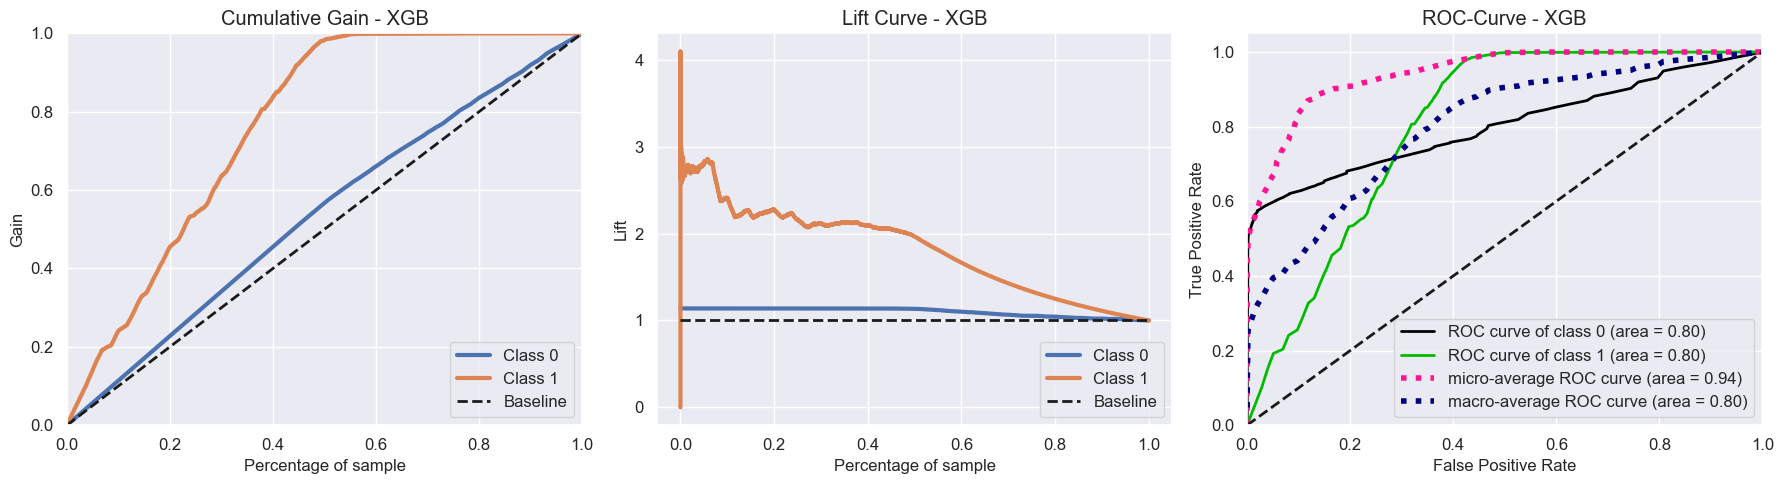

In [29]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb,ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_xgb, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

### 7.2 - KNN

In [30]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=8 )

# model training
knn_model.fit( x_training, y_training )

# model prediction - The generalization POWER
yhat_knn = knn_model.predict_proba( x_validation )

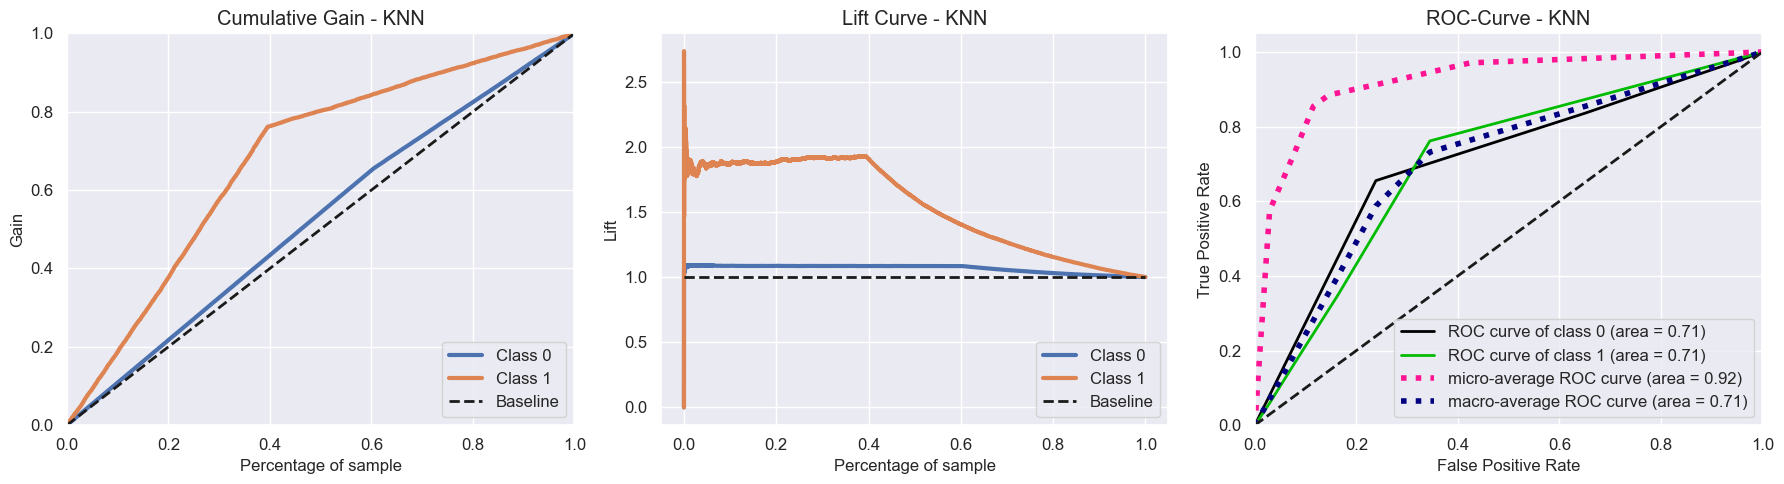

In [31]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain( y_validation, yhat_knn, ax=axs[0], title='Cumulative Gain - KNN' );

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_knn, ax=axs[1], title='Lift Curve - KNN');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_knn, ax=axs[2], title='ROC-Curve - KNN');

plt.tight_layout()

### 7.3 - Logistic Regression

In [ ]:
# model definition
lr_model = lm.LogisticRegression(penalty='elasticnet', C=0.01, class_weight='balanced', solver='saga', l1_ratio=0, random_state=0)

# model training
lr_model.fit( x_training, y_training )

# model prediction - The Generalization POWER
yhat_lr_model = lr_model.predict_proba( x_validation )

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lr_model, ax=axs[0],title='Cumulative Gain - Logistic Regression');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lr_model, ax=axs[1],title='Lift Curve - Logistic Regression');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_lr_model, ax=axs[2], title='ROC-Curve - Logistic Regression');

plt.tight_layout()

### 7.4 - Extra Trees

In [ ]:
# model definition
et_model = en.ExtraTreesClassifier( n_estimators=200, n_jobs=-1, random_state=42 )

# model training
et_model.fit( x_training, y_training )

# model prediction - The Generalization POWER
yhat_et_model = et_model.predict_proba( x_validation )

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_et_model, ax=axs[0],title='Cumulative Gain - Extra Trees');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_et_model, ax=axs[1],title='Lift Curve - Extra Trees');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_et_model, ax=axs[2], title='ROC-Curve - Extra Trees');

plt.tight_layout()

### 7.5 - Randon Forest

In [ ]:
# model definition
rf_model = en.RandomForestClassifier( n_estimators=2000, n_jobs=-1, random_state=42 )

# model training
rf_model.fit( x_training, y_training )

# model prediction - The Generalization POWER
yhat_rf_model = rf_model.predict_proba( x_validation )

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_rf_model, ax=axs[0],title='Cumulative Gain - Randon Forest');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_rf_model,ax=axs[1],title='Lift Curve - Randon Forest');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_rf_model, ax=axs[2], title='ROC-Curve - Randon Forest');

plt.tight_layout()

### 7.6 - Catboost Classifier

In [ ]:
# model definition
cb_model = CatBoostClassifier(
    iterations = 1000, # 1000 are ideal
    loss_function='MultiClass',
    bootstrap_type = "Bayesian",
    eval_metric = 'MultiClass',
    leaf_estimation_iterations = 100,
    random_strength = 0.5,
    depth = 7,
    l2_leaf_reg = 5,
    learning_rate=0.03,
    bagging_temperature = 0.5,
    task_type = "GPU",
)

# model training
cb_model.fit(x_training, y_training)

# model prediction
yhat_cb_model = cb_model.predict_proba( x_validation )

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_cb_model, ax=axs[0],title='Cumulative Gain - CatBoost');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_cb_model,ax=axs[1],title='Lift Curve - CatBoost');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_cb_model, ax=axs[2], title='ROC-Curve - CatBoost');

plt.tight_layout()

### 7.7 - Light gradient Boostin Machine Classifier Model

In [ ]:
# Model Definition
lgbm_model = lgbm.LGBMClassifier(learning_rate=0.00621, num_leaves=51, 
                         min_child_samples=67, subsample=0.938762, 
                         colsample_bytree=0.861679, random_state=0, subsample_freq=1,
                         n_estimators=1000, class_weight='balanced')

# Model training
model_lgbm = lgbm_model.fit( x_training, y_training )

# Model Prediction
yhat_lgbm = model_lgbm.predict_proba( x_validation )

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm, ax=axs[0],title='Cumulative Gain - LGBM');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm,ax=axs[1],title='Lift Curve - LGBM');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_lgbm, ax=axs[2], title='ROC-Curve - LGBM');

plt.tight_layout()

## 8 - MODEL PERFORMANCE

### 8.1 - KNN Model Performance

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_knn[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

KNN_performance = ml_performance('KNN_Model', precision_atK, recall_atK )
KNN_performance

### 8.2 - Logistic Regression Model Performance

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_lr_model[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=2000 )


# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=2000 )

lr_performance = ml_performance('LR Model', precision_atK, recall_atK )
lr_performance

### 8.3 - Extra Trees Model Performance

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_et_model[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

et_performance = ml_performance('ET Model', precision_atK, recall_atK )
et_performance

### 8.4 - Random Forest Model Performance

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_rf_model[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

rf_performance = ml_performance('RF Model', precision_atK, recall_atK )
rf_performance

### 8.5 -  XGB Model Performance

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_xgb[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

xgb_performance = ml_performance('XGB Model', precision_atK, recall_atK )
xgb_performance

### 8.6 - CatBoost Model Performance

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_cb_model[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

cb_performance = ml_performance('CB Model', precision_atK, recall_atK )
cb_performance

### 8.7 - Result for Light gradient Boostin Machine Classifier Model

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_lgbm[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=2000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=2000 )

lgbm_performance = ml_performance('LGBM Model', precision_atK, recall_atK )
lgbm_performance

### 8.8 - Results for all models

In [ ]:
model_performance = pd.concat( [KNN_performance, lr_performance, et_performance, rf_performance, cb_performance, xgb_performance, lgbm_performance] )
model_performance.sort_values('Precision_at_K', ascending= False)

## 9 - HYPERPARAMETER FINE TUNING

### 9.1 - Cross Validation

In [ ]:
# Concatenation train and validation dataset to use in cross-validation
df_cv = x_training.copy()
df_cv['response'] = y_training

df_aux = x_valid.copy()
df_aux['response'] = y_valid

df_cc = pd.concat([df_cv, df_aux])

In [ ]:
# Dictioary with models instantiated
#models = { 'KNN': knn_model,
#         'Logistic Regression': lr_model,
#         'Random Forest': rf_model,
#         'XGB Model': xgb_model,
#         'Ext. Model': et_model,
#         'RF Model': rf_model,
#         'CB Model': cb_model }
#
# Cross-validated models performance
#model_performance = pd.DataFrame()

#for key in models.keys():
#    performance_cv = cross_validation(5, key, models[key], df_cc, 20000)
#    model_performance = pd.concat([model_performance, performance_cv], axis=1)

#model_performance.T

In [ ]:
# Tabela com resultado do crossvalidation salvo na maquina.
cv_result = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/processed/crossvalidationresult.csv')
cv_result.sort_values('recall_at_k', ascending=False)

### 9.3 - LGBM Fine Tunning

In [ ]:
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback

In [ ]:
X = df6.drop( 'response', axis=1 ).reset_index(drop=True)
y = df6[['response']].reset_index(drop=True)

In [ ]:
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit( X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="binary_logloss", early_stopping_rounds=100, callbacks=[LightGBMPruningCallback(trial, "binary_logloss")],  # Add a pruning callback 
                 )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
# LGBM Fine Tuning with Grid Search

In [ ]:
'bagging_fraction': 0.8360034886892089,
 'feature_fraction': 0.1,
 'learning_rate': 0.09520535659597275,
 'max_bin': 20,
 'max_depth': 23,
 'min_data_in_leaf': 20,
 'min_sum_hessian_in_leaf': 100.0,
 'num_leaves': 80,
 'subsample': 0.03708289604738438,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False

#### 9.3.1 - LGBM After Fine Tuning

In [ ]:
# Model Definition
lgbm_model = lgbm.LGBMClassifier(n_estimators=10000, learning_rate=0.0887143433070807,is_unbalance=True, objective='binary', metric='auc', boost_from_average=False,
                                 num_leaves=820, max_depth=4, min_data_in_leaf=6300, lambda_l1=45, lambda_l2=10, min_gain_to_split=1.6091182169592595,
                                 bagging_fraction=0.7, bagging_freq=1, feature_fraction=0. )

# Model Training
model_lgbm = lgbm_model.fit( x_training, y_training )

# Model Prediction
yhat_lgbm = model_lgbm.predict_proba( x_validation )

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm, ax=axs[0],title='Cumulative Gain - LGBM');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm,ax=axs[1],title='Lift Curve - LGBM');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_lgbm, ax=axs[2], title='ROC-Curve - LGBM');

plt.tight_layout()

In [ ]:
# Copy Data
df8_unbalanced = x_valid.copy()
df8_unbalanced['response'] = y_valid.copy()

# Propensity score
df8_unbalanced['score'] = yhat_lgbm[:,1].tolist()

# sorted clients by score
df8_unbalanced = df8_unbalanced.sort_values( 'score', ascending=False )

# Compute precision at K
precision_atK = precision_at_k(df8_unbalanced, k=20000 )

# Compute precision at K
recall_atK = recall_at_k(df8_unbalanced, k=20000 )

lgbm_performance_cv = ml_performance('LGBM Model', precision_atK, recall_atK )
lgbm_performance_cv

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
pickle.dump(lgbm_model, open('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/src/models/lgbm_model.pkl', 'wb'))

## 10 - DEPLOY MODEL TO PRODUCTION

### 10.1 - HealthInsurance Class

In [ ]:
import pickle
import inflection
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path                             = ''
        self.annual_premium_scaler                 = pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb') )
        self.age_group_scaler                      = pickle.load( open( self.home_path + 'src/features/age_group_scaler.pkl', 'rb') )
        self.annual_premium_per_age_scaler         = pickle.load( open( self.home_path + 'src/features/annual_premium_per_age_scaler.pkl', 'rb') )
        self.annual_premium_per_day_scaler         = pickle.load( open( self.home_path + 'src/features/annual_premium_per_day_scaler.pkl', 'rb') )
        self.target_encode_vintage_month_scaler    = pickle.load( open( self.home_path + 'src/features/target_encode_vintage_month_scaler.pkl', 'rb') )
        self.age_scaler                            = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.vintage_scaler                        = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb') )
        self.frequency_encode_region_code_scaler   = pickle.load( open( self.home_path + 'src/features/frequency_encode_region_code_scaler.pkl', 'rb') )
        self.target_encode_gender_scaler           = pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb') )
        self.frequency_encode_policy_sales_scaler  = pickle.load( open( self.home_path + 'src/features/frequency_encode_policy_sales_scaler.pkl', 'rb') )
     
    def data_cleaning( self, df5 ):
 
        ## rename Columns
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df5.columns = cols_new
        
        return( df5 )

    def feature_engineering( self, df5 ):
        
        # Vintage Month - How many month that customer are on the company
        df5['vintage_month'] = round(df5['vintage'] / 31)

        # Annual Premium per day
        df5['annual_premium_per_day'] = df5['annual_premium']/df5['vintage']

        # Annual Premium per Age
        df5['annual_premium_per_age'] = df5['annual_premium']/df5['age']
        
        return( df5 )
    
    def data_preparation( self, df5 ):
              
        # Ajustando coluna vehicle_age
        df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)
        
        # Ajustando coluna vehicle_damage
        df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)
       
        # Age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )
    
        # Annual Premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )
        
        # Annual Premium per Day
        df5['annual_premium_per_day'] = self.annual_premium_per_day_scaler.transform( df5[['annual_premium_per_day']].values )
        
        # Annual Premium per Age
        df5['annual_premium_per_age'] = self.annual_premium_per_age_scaler.transform( df5[['annual_premium_per_age']].values )
        
        # Vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )
        
        # Vintage Month
        df5.loc[:, 'vintage_month'] = df5['vintage_month'].map( self.target_encode_vintage_month_scaler )
        
        # gender
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )
        
        # codigo de regiao
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.frequency_encode_region_code_scaler )
        
        # policy_sales_channel - Frequency Encoding / Target Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.frequency_encode_policy_sales_scaler )
        
        # Feature Selection
        cols_selected = ['annual_premium_per_day','vintage','annual_premium_per_age', 'annual_premium', 'age', 'region_code','vehicle_damage', 'policy_sales_channel', 'previously_insured', 'vintage_month', 'vehicle_age']

        return df5[cols_selected]
    

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict_proba( test_data )
        
        # join pred into the original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

### 10.2 - API Handler

In [ ]:
import pickle
import pandas as pd
import os
from flask                           import Flask, request, Response
from healthinsurance.healthinsurance import HealthInsurance

# logading model
model = pickle.load( open( 'src/models/lgbm_model.pkl', 'rb' ) )
                          
# initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
               
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
    
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # multiple examples
            
        # Instantiate Rossmann Class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
              
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # Data Preparation
        df3 = pipeline.data_preparation( df2 )
                              
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run('0.0.0.0')

#    port = os.environ.get('PORT', 5000)
#    app.run( host='0.0.0.0', port=port )

### 10.3 - API Tester

In [ ]:
import requests
import pandas as pd

In [ ]:
# Load Datasets
df_test = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/Health_Insurance_Cross_Sell/data/raw/test.csv')

In [ ]:
df_test = df_test.sample(10)

In [ ]:
df_test.head()

In [ ]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
 # API Call
#url = 'https://healthinsurance-api.onrender.com/healthinsurance/predict'
url = 'http://127.0.0.1:5000/healthinsurance/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d2 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d2